# Difference Causal Inference (DCI) Tutorial for Gene Expression Data
- DCI [1,2] directly estimates the differences between two causal graphs given gene expression data from two conditions such as healthy and diseased states, different cell types or different time points.
- Changes between two causal graphs are the edges that appeared, disappeared or changed weight between the two states.
- DCI infers the differences between causal graphs directly without estimating each possibly large causal graph separately.


In this tutorial, we apply DCI to bulk RNA-seq data collected from two ovarian cancer patient cohorts with
different survival rates to obtain the causal difference gene regulatory network. For applications of DCI to larger gene expression datasets, we recommend running DCI on a subset of genes (e.g. differentially expressed genes). For most robust results, we recommend using DCI with stability selection [3].

DCI algorithm consists of three main steps:
1. Initialization with a difference undirected graph.
2. Estimation of the skeleton of the difference causal graph.
3. Orienting edges in the difference causal graph.

References:

[1] Belyaeva, A., Squires, C., & Uhler, C. (2020). DCI: Learning Causal Differences between Gene Regulatory Networks. In submission.           
[2] Wang, Y., Squires, C., Belyaeva, A., & Uhler, C. (2018). Direct estimation of differences in causal graphs. In Advances in Neural Information Processing Systems (pp. 3770-3781).                        
[3] Meinshausen, N. and Buhlmann, P. (2010). Stability selection.
Journal of the Royal Statistical Society: Series B (Statistical Methodology), 72(4), pp.417-473.

### Table of Contents

<a href='#install'>Installation</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#pre'>Data preprocessing</a>
<br/>
<a href='#DCI'>Running DCI</a>
<br/>
<a href='#graph'>Visualizing difference causal graph</a>
<br/>
<a href='#DCI_stability'>Running DCI with stability selection</a>
<br/>

<a id="install"></a>

### Installation 

DCI can be installed directly in this notebook with:

In [1]:
!pip install --user causaldag

Import causaldag package that DCI is part of as well as auxilary python packages for data processing and plotting.

In [2]:
from causaldag import dci, dci_stability_selection
from causaldag import get_directed_and_undirected_edges
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import StandardScaler

# Matplotlib command for Jupyter notebooks only
%matplotlib inline

<a id="data"></a>

### Loading data

Read in two gene expression datasets, corresponding to two conditions of interest. DCI expects two matrices of size $n_1 \times p$ and $n_2 \times p$, where $n_1$ and $n_2$ are the number of samples in each dataset and $p$ corresponds to the number of genes. We recommend transforming RNA-seq counts with $\log(x + 1)$ such that the distribution of each gene is approximately Gaussian. 

In [3]:
path_in = 'data/'
gene_exp_diff_1 = pd.read_csv(os.path.join(path_in, 'apoptosis_1.csv'), index_col=0)
gene_exp_diff_2 = pd.read_csv(os.path.join(path_in, 'apoptosis_2.csv'), index_col=0)
gene_names = gene_exp_diff_1.columns.values

In [4]:
gene_exp_diff_1.shape, gene_exp_diff_2.shape

((83, 10), (168, 10))

In [5]:
gene_names

array(['TP53', 'TNFSF10', 'IL1R1', 'PRKAR2B', 'FAS', 'ENDOG', 'CSF2RB',
       'AIFM1', 'BIRC3', 'PIK3R1'], dtype=object)

<a id="pre"></a>
### Data preprocessing
Prior to running DCI, the data should be at least mean cenetered (along with any other transformations).

In [6]:
scaler = StandardScaler(with_std=False)
X1 = scaler.fit_transform(gene_exp_diff_1.values)
X2 = scaler.fit_transform(gene_exp_diff_2.values)

<a id="DCI"></a>
### Running DCI
Run DCI on the two datasets with default parameters or by specifying your own hyperparameters.

In [12]:
d_dag = dci(X1, X2, alpha_ug = 0.001, alpha_skeleton=0.5, alpha_orient=0.001, max_set_size=3, verbose=1)

Running KLIEP to get difference undirected graph...
Maximum iteration reached
Difference undirected graph:  [(0, 2), (0, 4), (0, 8), (0, 9), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 6), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 8), (5, 9), (6, 7), (6, 8), (7, 8), (7, 9), (8, 9)]
DCI skeleton estimation...
Removing edge 0-2 since p-value=0.82759 > alpha=0.50000
Removing edge 0-4 since p-value=0.56434 < alpha=0.50000
Removing edge 0-8 since p-value=0.57503 > alpha=0.50000
Removing edge 0-9 since p-value=0.95151 > alpha=0.50000
Removing edge 1-3 since p-value=0.55181 > alpha=0.50000
Removing edge 1-4 since p-value=0.77913 > alpha=0.50000
Removing edge 1-6 since p-value=0.64699 < alpha=0.50000
Removing edge 1-7 since p-value=0.51028 < alpha=0.50000
Removing edge 1-8 since p-value=0.62069 < alpha=0.50000
Removing edge 1-9 since p-value=0.84008 > alpha=0.50000
Removing edge 2-3 since p-value=

<a id="graph"></a>
### Visualizing causal graphs
Plot directed and undirected edges corresponding to the estimated difference causal graph.

In [13]:
def visualize_ddag(d_dag, gene_names):
    """
    Plots causal graph.

    Parameters
    ----------
    d_dag: array, shape = [n_features, n_features]
        Adjacency matrix corresponding to partially directed acyclic graph (can contain both directed and undirected edges.)
    gene_names: array, shape = [n_features,]
        Names of genes corresponding to each node in the d_dag.
    """
    # obtain directed and undirected edges separately
    ddag_directed, ddag_undirected = get_directed_and_undirected_edges(d_dag)
    # construct networkx graphs for directed and undirected edges separately and together
    G = nx.from_numpy_matrix(d_dag, create_using=nx.MultiDiGraph())
    G_directed = nx.from_numpy_matrix(ddag_directed, create_using=nx.MultiDiGraph())
    G_undirected = nx.from_numpy_matrix(ddag_undirected, create_using=nx.Graph())
    # rename nodes from numbers to gene names
    node_label_mapping = {}
    for i in range(len(gene_names)):
        node_label_mapping[i] = gene_names[i]
    G = nx.relabel_nodes(G, node_label_mapping)
    G_directed = nx.relabel_nodes(G_directed, node_label_mapping)
    G_undirected = nx.relabel_nodes(G_undirected, node_label_mapping)
    # draw causal graph
    pos = nx.circular_layout(G)
    nx.draw(G_directed, arrowstyle='->', arrowsize=20, width = 2, with_labels=True, pos=pos)
    nx.draw(G_undirected, width = 2, with_labels=True, pos=pos)

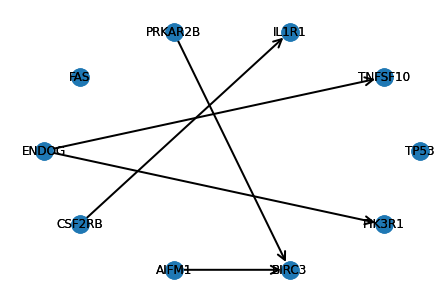

In [14]:
visualize_ddag(d_dag, gene_names)

<a id="DCI_stability"></a>
### Running DCI with stability selection
Since running DCI requires choosing several hyperparameters, we also implemented DCI with stability selection, which computes the difference causal graph that is robust across different hyperparameter settings. There are three main hyperparameters corresponding to the three steps of the DCI algorithm:
1. List of hyperparameters for L1 regularization of the KLIEP algorithm, which computes the difference undirected graph (alpha_ug_grid).
2. List of significance levels for hypothesis testing to determine the skeleton of the difference causal graph (alpha_skeleton_grid).
3. List of significance levels for hypothesis testing to orient edges of the difference causal graph (alpha_orient_grid).

To speed up computation, we recommend to run DCI with stability selection in parallel.

In [15]:
d_dag_stable, stability_scores = dci_stability_selection(X1, X2, alpha_ug_grid = [0.001, 0.01], alpha_skeleton_grid = [0.1, 0.5], alpha_orient_grid = [0.001, 0.01], edge_threshold=0, max_set_size=3, n_jobs = 10, n_bootstrap_iterations=50, random_state=42, verbose=1)

Fitting estimator for alpha_ug = 0.00100, alpha_skeleton = 0.10000, alpha_orient = 0.00100 with 50 bootstrap iterations


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting estimator for alpha_ug = 0.00100, alpha_skeleton = 0.10000, alpha_orient = 0.01000 with 50 bootstrap iterations


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting estimator for alpha_ug = 0.00100, alpha_skeleton = 0.50000, alpha_orient = 0.00100 with 50 bootstrap iterations


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    3.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting estimator for alpha_ug = 0.00100, alpha_skeleton = 0.50000, alpha_orient = 0.01000 with 50 bootstrap iterations


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    4.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting estimator for alpha_ug = 0.01000, alpha_skeleton = 0.10000, alpha_orient = 0.00100 with 50 bootstrap iterations


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting estimator for alpha_ug = 0.01000, alpha_skeleton = 0.10000, alpha_orient = 0.01000 with 50 bootstrap iterations


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting estimator for alpha_ug = 0.01000, alpha_skeleton = 0.50000, alpha_orient = 0.00100 with 50 bootstrap iterations


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting estimator for alpha_ug = 0.01000, alpha_skeleton = 0.50000, alpha_orient = 0.01000 with 50 bootstrap iterations


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.8s finished


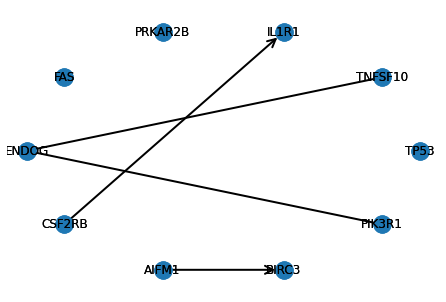

In [16]:
visualize_ddag(d_dag_stable, gene_names)